In [17]:
import rasterio
from rasterio.mask import mask
import geopandas as gpd
import numpy as np
from rasterio.plot import reshape_as_raster, reshape_as_image
import pandas as pd
import matplotlib.pyplot as plt
from rasterio.plot import show
import cv2
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from tqdm import tqdm

## Loading Data

In [18]:
nm_shp = gpd.read_file("JamaicaNonmangroveLabels.shp")
m_shp = gpd.read_file("JamaicaMangroveLabelsFixed.shp")

nm_geoms = nm_shp.geometry
m_geoms = m_shp.geometry

In [19]:
src = rasterio.open("JamaicaFeaturesNoSAR.tif") 
mask_src = rasterio.open("JamaicaImageMask.tif") 
m_image, m_transform = mask(src, m_geoms, crop=True) 
nm_image, nm_transform = mask(src, nm_geoms, crop=True)

#Getting mask for each class
mmask, mmask_transform = mask(mask_src, m_geoms, crop=True)
nmmask, nmmask_transform = mask(mask_src, nm_geoms, crop=True)

# Reshaping Data

In [20]:
m_idx = np.squeeze(((reshape_as_image(mmask) == 1)), axis=-1) 
nm_idx = np.squeeze((reshape_as_image(nmmask) == 1), axis=-1)
m_pix = reshape_as_image(m_image)[m_idx]
nm_pix = reshape_as_image(nm_image)[nm_idx]
m_pix = m_pix[np.all(m_pix != 0, axis=1)]
nm_pix = nm_pix[np.all(nm_pix != 0, axis=1)]
x = np.concatenate((m_pix, nm_pix), axis = 0)
y = np.concatenate((np.zeros((m_pix.shape[0]))+1, np.zeros((nm_pix.shape[0]))))
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

np.concat((up_img[m_idx], up_img[nm_idx]))

x, y (original data)
new_x, new_y (downsampled model training)
up_y = np.concat((up_img[m_idx], up_img[nm_idx]))
(upsampled from downsampled labels)

# Downsampling Methods

In [21]:
def downsampling_2d(img, scale_percent):
    width = int(img.shape[1] * scale_percent)
    height = int(img.shape[0] * scale_percent)
    dim = (width, height)
    # downsampling image
    resized = cv2.resize(img, dim, interpolation = cv2.INTER_LINEAR)
    return resized

In [22]:
def mask_downsampling(mask, scale_percent):
    img = mask[0]
    resized = downsampling_2d(img, scale_percent)
    return np.array([resized])

In [23]:
def image_downsampling(imgs, scale_percent):
    img_down = []
    for i in range(len(imgs)):
        img_new = downsampling_2d(imgs[i], scale_percent)
        img_down.append(img_new)
    img_down = np.array(img_down)
    return img_down 

In [24]:
def upsampling_2d(ori_img, img):
    width_out = ori_img.shape[1]
    height_out = ori_img.shape[0]
    dim_out = (width_out, height_out)
    # upsampling image 
    resized = cv2.resize(img, dim_out, interpolation = cv2.INTER_NEAREST)
    return resized

In [25]:
def mask_upsampling(ori_mask, mask):
    img = mask[0]
    ori_img = ori_mask[0]
    resized = upsampling_2d(ori_img, img)
    return np.array([resized])

In [26]:
def image_upsampling(ori_img, imgs):
    img_up = []
    for i in range(len(imgs)):
        img_new = upsampling_2d(ori_img[i], imgs[i])
        img_up.append(img_new)
    img_up = np.array(img_up)
    return img_up 

# Train the original image

In [11]:
ert_model = ExtraTreesClassifier(n_jobs=4)
ert_model.fit(x_train, y_train)

ExtraTreesClassifier(n_jobs=4)

In [12]:
img_o = reshape_as_image(src.read())
array_o = img_o.reshape(img_o.shape[0] * img_o.shape[1], img_o.shape[2])
output_o = ert_model.predict(array_o)

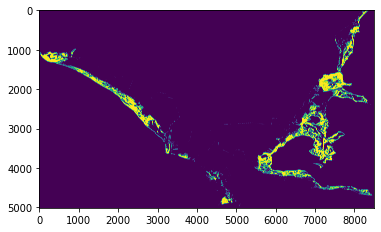

<AxesSubplot:>

In [14]:
output_img_o = output_o.reshape(img_o.shape[0], img_o.shape[1], 1)
show(output_img_o)

In [15]:
np.save('img_o.npy', output_img_o)

## can read the trained image directly here

In [27]:
img_o_load = np.load('img_o.npy')

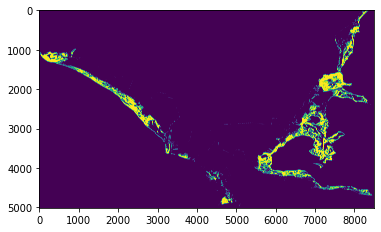

<AxesSubplot:>

In [28]:
show(img_o_load)

# Crop the image with mask

In [15]:
import PIL
from PIL import Image
src_mask_img = Image.open("JamaicaImageMask.tif")
src_mask_img_arr = np.array(src_mask_img)
src_mask_img_arr.shape

(5012, 8500)

In [39]:
#invalid_idx = np.argwhere(src_mask_img_arr == False).tolist()
#invalid_idx 

In [40]:
valid_idx = np.argwhere(src_mask_img_arr == True).tolist()
#valid_idx 

In [91]:
valid_idx_new = np.argwhere(src_mask_img_arr.flatten() == True).flatten().tolist()#.tolist()

In [37]:
new_o = img_o_load.flatten()
new_o

array([0., 0., 0., ..., 0., 0., 0.])

In [93]:
new_o[valid_idx_new]

array([0., 0., 0., ..., 0., 0., 0.])

In [96]:
#(np.take(new_o, valid_idx_new, 0) == new_o[valid_idx_new]).mean()

1.0

# Scale percentage

In [6]:
nmimg_height_lst = np.linspace(3525/ 5, 3525, num = 20)
nmimg_height_lst

array([ 705.        ,  853.42105263, 1001.84210526, 1150.26315789,
       1298.68421053, 1447.10526316, 1595.52631579, 1743.94736842,
       1892.36842105, 2040.78947368, 2189.21052632, 2337.63157895,
       2486.05263158, 2634.47368421, 2782.89473684, 2931.31578947,
       3079.73684211, 3228.15789474, 3376.57894737, 3525.        ])

In [7]:
scale_percent_lst = nmimg_height_lst/3525
scale_percent_lst 

array([0.2       , 0.24210526, 0.28421053, 0.32631579, 0.36842105,
       0.41052632, 0.45263158, 0.49473684, 0.53684211, 0.57894737,
       0.62105263, 0.66315789, 0.70526316, 0.74736842, 0.78947368,
       0.83157895, 0.87368421, 0.91578947, 0.95789474, 1.        ])

In [70]:
mini_scale_percent_lst = np.array([0.02, 0.04, 0.06, 0.08, 0.1, 0.12, 0.14, 0.16, 0.18])

# Method for training one lower resolution image

In [8]:
def downsample_method(p):
    new_mmask = mask_downsampling(mmask, p)
    new_nmmask = mask_downsampling(nmmask, p)
    new_m_image = image_downsampling(m_image, p)
    new_nm_image = image_downsampling(nm_image, p)
    #reshape original image and downsampling
    ori_img = reshape_as_image(src.read())
    new_img = image_downsampling(src.read(), p)
    new_img = reshape_as_image(new_img)
    array = new_img.reshape(new_img.shape[0] * new_img.shape[1], new_img.shape[2])
    #use down sampled masks and images to create train-test split
    new_m_idx = np.squeeze(((reshape_as_image(new_mmask) == 1)), axis=-1) 
    new_nm_idx = np.squeeze((reshape_as_image(new_nmmask) == 1), axis=-1)
    new_m_pix = reshape_as_image(new_m_image)[new_m_idx]
    new_nm_pix = reshape_as_image(new_nm_image)[new_nm_idx]
    new_m_pix = new_m_pix[np.all(new_m_pix != 0, axis=1)]
    new_nm_pix = new_nm_pix[np.all(new_nm_pix != 0, axis=1)]
    new_x = np.concatenate((new_m_pix, new_nm_pix), axis = 0)
    new_y = np.concatenate((np.zeros((new_m_pix.shape[0]))+1, np.zeros((new_nm_pix.shape[0]))))
    new_x_train, new_x_test, new_y_train, new_y_test = train_test_split(new_x, new_y, test_size=0.20, random_state=42)
    new_clf = ExtraTreesClassifier(n_jobs=4)
    new_clf.fit(new_x_train, new_y_train)
    output = new_clf.predict(array)
    output_img = output.reshape(new_img.shape[0], new_img.shape[1], 1)
    #upsample calssified image
    ori_img1 = ori_img[:,:,0]
    width_out = ori_img1.shape[1]
    height_out = ori_img1.shape[0]
    dim_out = (width_out, height_out)
    up_img = cv2.resize(output_img[:,:,0], dim_out, interpolation = cv2.INTER_NEAREST)
    return up_img

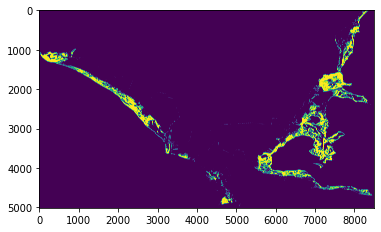

<AxesSubplot:>

In [79]:
show(output_img_o)

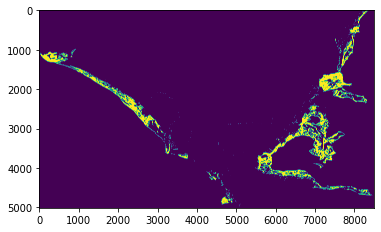

<AxesSubplot:>

In [78]:
show(downsample_method(0.2))

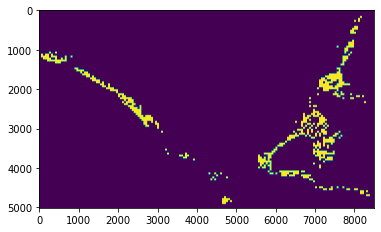

<AxesSubplot:>

In [47]:
show(downsample_method(0.02))

# Fix mask issue

In [ ]:
a4 = downsample_method(0.04)

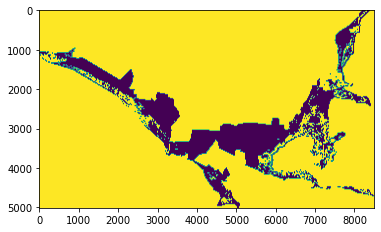

<AxesSubplot:>

In [76]:
show(a4)

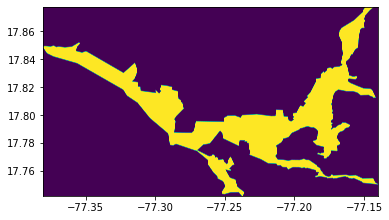

<AxesSubplot:>

In [63]:
show(mask_src)

In [35]:
import PIL
from PIL import Image
src_mask_img = Image.open("JamaicaImageMask.tif")
src_mask_img_arr = np.array(src_mask_img)
src_mask_img_arr.shape

(5012, 8500)

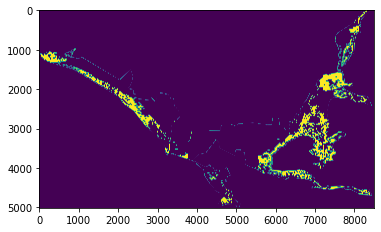

<AxesSubplot:>

In [80]:
show(src_mask_img_arr*a4)

In [82]:
new_a4 = src_mask_img_arr*a4

In [83]:
f1_score(output_img_o.flatten(), new_a4.flatten())

0.7378705650925502

# Trained images with different resolutions

In [25]:
img_lst = []
for p in tqdm(scale_percent_lst):
    img_lst.append(downsample_method(p))

100%|███████████████████████████████████████████| 20/20 [18:40<00:00, 56.02s/it]


In [30]:
mini_img_lst = []
for p in tqdm(mini_scale_percent_lst):
    mini_img_lst.append(downsample_method(p))

100%|█████████████████████████████████████████████| 9/9 [00:23<00:00,  2.58s/it]


In [32]:
np.save('img_lst.npy', img_lst)

In [31]:
np.save('mini_img_lst.npy', mini_img_lst)

## can load the trained image lists directly here

In [29]:
img_load = np.load('img_lst.npy')

In [32]:
mini_img_load = np.load('mini_img_lst.npy')

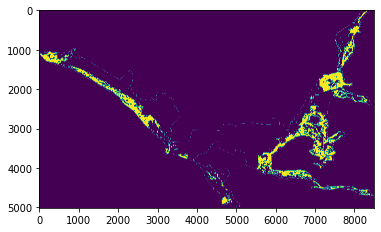

<AxesSubplot:>

In [83]:
show(mini_img_load[2]*src_mask_img_arr)

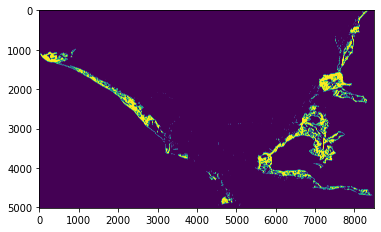

<AxesSubplot:>

In [74]:
show(img_load[0])

# Confusion matix 
(true positive rate, true negative rate, accuracy, F1 score)

In [33]:
#true_postive rate -- sensitivity, recall, tp/(tp+fn)
#true_negative rate -- specificity tn/(tn+fp)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

- Top left quadrant = True Positives = Number of benign labelled as benign
- Bottom right quadrant = True Negatives = Number of malignant labelled as malignant
- Top right quadrant = False Positives = Number of benign labelled as malignant
- Bottom left quadrant = False Negatives = Number of malignant labelled as benign

# compute true positive and true negative

In [40]:
true_postive_rate_lst = []
true_negative_rate_lst = []
for up_img in tqdm(img_load):
    new_up_img = src_mask_img_arr*up_img
    new_c = confusion_matrix(output_img_o.flatten(), new_up_img.flatten())
    TP = new_c[0, 0]
    FP = new_c[0, 1]
    FN = new_c[1, 0]
    TN = new_c[1, 1]
    new_true_positive_rate = TP/(TP+FN)
    new_true_negative_rate = TN/(TN+FP)
    true_postive_rate_lst.append(new_true_positive_rate)
    true_negative_rate_lst.append(new_true_negative_rate)

100%|███████████████████████████████████████████| 20/20 [06:25<00:00, 19.27s/it]


# Compute Accuracy

In [13]:
#Old acc list without removing invalid pixel
# acc_lower_bound_lst = []
# for up_img in img_load:
#     new_up_img = src_mask_img_arr*up_img
#     acc_lower_bound_lst.append((output_img_o.flatten()==new_up_img.flatten()).mean()*96.26)

In [56]:
(img_load[-1].flatten()[valid_idx_new] == new_o.flatten()[valid_idx_new]).mean()

0.9885611532910159

In [85]:
new_acc_lower_bound_lst = []
for up_img in img_load:
    new_up_img = src_mask_img_arr*up_img
    new_acc_lower_bound_lst.append((new_o[valid_idx_new]==new_up_img.flatten()[valid_idx_new]).mean())#*96.26)

In [78]:
#Old acc list without removing invalid pixel
# mini_acc_lower_bound_lst = []
# for up_img in mini_img_lst:
#     new_up_img = src_mask_img_arr*up_img
#     mini_acc_lower_bound_lst.append((output_img_o.flatten()==new_up_img.flatten()).mean()*96.26)

In [67]:
new_mini_acc_lower_bound_lst = []
for up_img in mini_img_load:
    new_up_img = src_mask_img_arr*up_img
    new_mini_acc_lower_bound_lst.append((new_o[valid_idx_new]==new_up_img.flatten()[valid_idx_new]).mean())#*96.26)

In [46]:
#mini_acc_lower_bound_lst = (np.array(mini_acc_lower_bound_lst)*0.01).tolist()

In [68]:
new_mini_acc_lower_bound_lst = (np.array(new_mini_acc_lower_bound_lst)*0.9626).tolist()

# Compute F1 score

In [15]:
from sklearn.metrics import f1_score

In [44]:
f1_lst = []
for up_img in tqdm(img_lst):
    new_up_img = src_mask_img_arr*up_img
    f1_lst.append(f1_score(output_img_o.flatten(), new_up_img.flatten()))

100%|███████████████████████████████████████████| 20/20 [07:19<00:00, 21.98s/it]


In [49]:
nmimg_height_lst_2 = np.linspace(3525/ 50, 3525, num = 10)
scale_percent_lst_2 = nmimg_height_lst_2/3525
scale_percent_lst_2

array([0.02      , 0.12888889, 0.23777778, 0.34666667, 0.45555556,
       0.56444444, 0.67333333, 0.78222222, 0.89111111, 1.        ])

In [ ]:
img_lst_2 = []
for p in tqdm(scale_percent_lst_2):
    img_lst.append(downsample_method(p))

 80%|███████████████████████████████████▏        | 8/10 [03:33<01:36, 48.18s/it]

In [ ]:
f1_lst_2 = []
for up_img in tqdm(img_lst_2):
    new_up_img = src_mask_img_arr*up_img
    f1_lst_2.append(f1_score(output_img_o.flatten(), new_up_img.flatten()))

In [71]:
new_scale_percent_lst = [0.02, 0.03, 0.2 , 0.36842105,0.41052632, 0.49473684, 0.5368421052631579, 0.6631578947368421, 0.8736842105263158, 1]

# Plot
## ⚠️⚠️⚠️ please do not rerun this portion since some of the variables have changed, feel free to create new plots with new blocks

Text(0, 0.5, 'Accuracy')

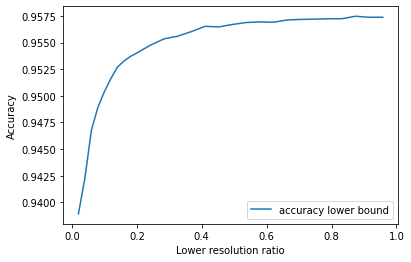

In [83]:
#acc plot not removing invalid pixel
new_df = pd.DataFrame()
new_df['accuracy lower bound'] = mini_acc_lower_bound_lst+acc_lower_bound_lst[:-1]
new_df['Lower resolution ratio'] = mini_scale_percent_lst.tolist()+(scale_percent_lst[:-1]).tolist()
new_df = new_df.set_index('Lower resolution ratio')
new_df.plot(kind='line')
plt.ylabel("Accuracy")
#plt.axvline(0.2, color='green', linestyle='dashed')
#plt.text(0.22, 0.955, 'ratio = 0.2', fontsize=8);

Text(0, 0.5, 'Accuracy')

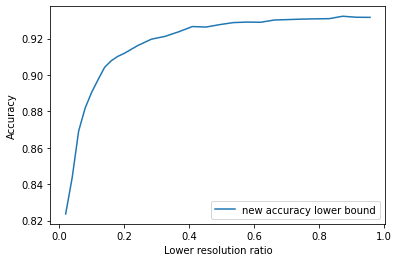

In [89]:
# acc plot after removing invalid pixel
new_df = pd.DataFrame()
new_df['new accuracy lower bound'] = new_mini_acc_lower_bound_lst+new_acc_lower_bound_lst[:-1]
new_df['Lower resolution ratio'] = mini_scale_percent_lst.tolist()+(scale_percent_lst[:-1]).tolist()
new_df = new_df.set_index('Lower resolution ratio')
new_df.plot(kind='line')
plt.ylabel("Accuracy")

In [65]:
acc_lower_bound_lst = (np.array(acc_lower_bound_lst)*0.01).tolist()

Text(0, 0.5, 'percentage')

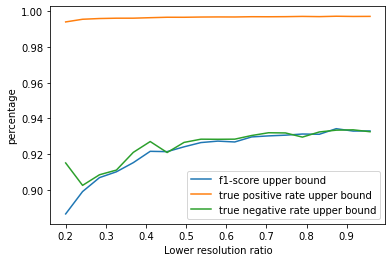

In [68]:
new_df = pd.DataFrame()
#new_df['accuracy lower bound'] = acc_lower_bound_lst[:-1]
new_df['f1-score upper bound'] = f1_lst[:-1]
new_df['true positive rate upper bound'] = true_postive_rate_lst[: -1]
new_df['true negative rate upper bound'] = true_negative_rate_lst[:-1]
new_df['Lower resolution ratio'] = scale_percent_lst[:-1]
new_df = new_df.set_index('Lower resolution ratio')
new_df.plot(kind='line')
plt.ylabel("percentage")
#plt.axvline(0.2, color='green', linestyle='dashed')
#plt.text(0.22, 0.955, 'ratio = 0.2', fontsize=8);

# Draft

In [4]:
#openCV resize
#https://www.tutorialkart.com/opencv/python/opencv-python-resize-image/

In [5]:
from scipy import ndimage
import matplotlib.pyplot as plt

In [32]:
identity_matrix = np.identity(100)
identity_matrix

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

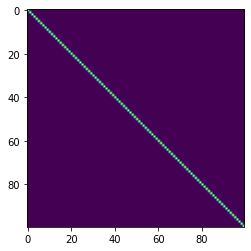

<AxesSubplot:>

In [33]:
show(identity_matrix)

In [34]:
identity_matrix_down = downsampling_2d(identity_matrix, 0.1)

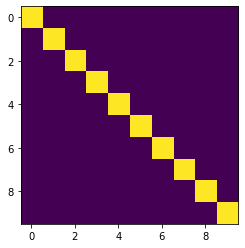

<AxesSubplot:>

In [35]:
show(identity_matrix_down)

In [36]:
identity_matrix_up = upsampling_2d(identity_matrix, identity_matrix_down)

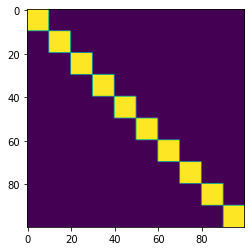

<AxesSubplot:>

In [37]:
show(identity_matrix_up)

In [20]:
def downsampling_and_upsampling_2d(img, scale_percent):
    width = int(img.shape[1] * scale_percent)
    height = int(img.shape[0] * scale_percent)
    dim = (width, height)
    # downsampling image
    resized = cv2.resize(img, dim, interpolation = cv2.INTER_LINEAR)
    width_out = img.shape[1]
    height_out = img.shape[0]
    dim_out = (width_out, height_out)
    # upsampling image 
    resized = cv2.resize(resized, dim_out, interpolation = cv2.INTER_NEAREST)
    return resized

In [19]:
def downsampling_2d(img, scale_percent):
    width = int(img.shape[1] * scale_percent)
    height = int(img.shape[0] * scale_percent)
    dim = (width, height)
    # downsampling image
    resized = cv2.resize(img, dim, interpolation = cv2.INTER_LINEAR)
    width_out = img.shape[1]
    height_out = img.shape[0]
    dim_out = (width_out, height_out)
    # upsampling image 
    resized = cv2.resize(resized, dim_out, interpolation = cv2.INTER_NEAREST)
    return resized
def mask_downsampling(mask, scale_percent):
    img = mask[0]
    resized = downsampling_2d(img, scale_percent)
    return np.array([resized])
def image_downsampling(imgs, scale_percent):
    img_down = []
    for i in range(len(imgs)):
        img_new = downsampling_2d(imgs[i], scale_percent)
        img_down.append(img_new)
    img_down = np.array(img_down)
    return img_down 